In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from scipy.special import j0, jn_zeros
from numpy.fft import rfft, rfftfreq

In [2]:
propiedades = {
    0: "lower x edge [m]",
    1: "upper x edge [m]",
    2: "lower y edge [m]",
    3: "upper y edge [m]",
    4: "cell volume [m3]",
    5: "density [kg/m3]",
    6: "velocity x [m/s]",
    7: "velocity y [m/s]",
    8: "temperature [eV]",
    9: "SDE [W/m3]",
    10: "P_therm [Pa]",
    11: "P_rad [Pa]",
    12: "P_total [Pa]",
    13: "internal energy [J/kg]",
    14: "cv [J/kg/K]",
    15: "rho*cv [J/m3/K]",
    16: "sound speed [m/s]",
    17: "charge state",
    18: "electron density [e/m3]",
    19: "kinetic energy",
    20: "nmat",
    21: "fvol 0",
    22: "fvol 1",
    23: "fvol 2",
    24: "fvol 3",
    25: "fvol 4",
    26: "fvrho 0",
    27: "fvrho 1",
    28: "fvrho 2",
    29: "fvrho 3",
    30: "fvrhoe 0",
    31: "fvrhoe 1",
    32: "fvrhoe 2",
    33: "fvrhoe 3"
}


2D

In [ ]:
def calcular_RT_total(
    ruta_hdf5,
    beta=1.0,
    eps=1e-12,
    dtype=np.float32
):
    """
    Calcula la tasa RT total sin cargar arrays completos en memoria.
    Usa memoria mapeada y bucle temporal.
    """

    import numpy as np
    import os

    # -----------------------------
    # Carpeta
    # -----------------------------
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    # -----------------------------
    # MEMORIA MAPEARDA (CLAVE)
    # -----------------------------
    P   = np.load(os.path.join(carpeta, "prop_12.npy"), mmap_mode="r")
    rho = np.load(os.path.join(carpeta, "prop_05.npy"), mmap_mode="r")
    Vz  = np.load(os.path.join(carpeta, "prop_07.npy"), mmap_mode="r")
    Vr  = np.load(os.path.join(carpeta, "prop_06.npy"), mmap_mode="r")

    Nt, Nz, Nr = P.shape

    # -----------------------------
    # Archivo de salida (memmap)
    # -----------------------------
    ruta_salida = os.path.join(carpeta, "prop_RT_1.npy")
    RT = np.lib.format.open_memmap(
        ruta_salida,
        mode="w+",
        dtype=dtype,
        shape=(Nt, Nz, Nr)
    )

    # -----------------------------
    # Loop temporal
    # -----------------------------
    for t in range(Nt):
        if t % 10 == 0:
            print(f"RT total: {t}/{Nt}", end="\r")

        P_t   = P[t]
        rho_t = rho[t]
        Vz_t  = Vz[t]
        Vr_t  = Vr[t]

        dP_dz, dP_dr = np.gradient(P_t)

        gradP = np.sqrt(dP_dz**2 + dP_dr**2)
        Lp = np.abs(P_t) / (gradP + eps)
        k  = 1.0 / (Lp + eps)

        a_eff = gradP / (rho_t + eps)
        Va = np.sqrt(Vz_t**2 + Vr_t**2)

        sigma_RT = np.sqrt(a_eff * k / (1.0 + k * Lp)) 
        sigma_RT[sigma_RT < 0] = 0.0

        RT[t] = np.nan_to_num(sigma_RT)

    print("\n✔ RT total calculada correctamente")
    print("✔ Guardada en:", ruta_salida)

    return ruta_salida


def ver_RT_total_por_indice(ruta_hdf5, t_index):
    """
    Visualiza la tasa de crecimiento RT total σ_RT(z,r)
    en un instante temporal concreto.
    """

    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt

    # -----------------------------
    # Carpeta de datos
    # -----------------------------
    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_rt = os.path.join(carpeta, "prop_RT_1.npy")
    if not os.path.exists(ruta_rt):
        raise FileNotFoundError("No existe prop_RT.npy. Ejecuta calcular_RT_total().")

    RT = np.load(ruta_rt)  # (Nt, Nz, Nr)
    Nt, Nz, Nr = RT.shape

    if t_index < 0 or t_index >= Nt:
        raise ValueError(f"t_index fuera de rango [0, {Nt-1}]")

    # -----------------------------
    # Leer tiempos
    # -----------------------------
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for ds in f.values():
            if "time" in ds.attrs:
                tiempos.append(ds.attrs["time"][0])

    tiempos = np.array(tiempos)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt, dtype=float)

    t_ns = tiempos[t_index] * 1e9

    # -----------------------------
    # Plot
    # -----------------------------
    frame = RT[t_index]
    vmin, vmax = np.percentile(frame, [2, 98])

    plt.figure(figsize=(6,5))
    plt.imshow(
        frame,
        origin="lower",
        cmap="inferno",
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("R [µm]")
    plt.ylabel("Z [µm]")
    plt.title(rf"Término desestabilizador $\sigma_{{RT}}$ | t = {t_ns:.3f} ns")
    plt.colorbar(label=r"$\sigma_{RT}$ [s$^{-1}$]")
    plt.tight_layout()
    plt.show()

    


In [ ]:
def animar_RT_total_mp4(
    ruta_hdf5,
    fps=10,
    percentiles=(2, 98)
):
    """
    Genera un MP4 de la evolución temporal de la tasa RT total.
    """

    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, FFMpegWriter

    # -----------------------------
    # Carpeta de datos
    # -----------------------------
    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_rt = os.path.join(carpeta, "prop_RT_1.npy")
    if not os.path.exists(ruta_rt):
        raise FileNotFoundError("No existe prop_RT.npy. Ejecuta calcular_RT_total().")

    RT = np.load(ruta_rt)  # (Nt, Nz, Nr)
    Nt, Nz, Nr = RT.shape

    # -----------------------------
    # Leer tiempos (en segundos)
    # -----------------------------
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for ds in f.values():
            if "time" in ds.attrs:
                tiempos.append(ds.attrs["time"][0])

    tiempos = np.array(tiempos, dtype=float)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt, dtype=float)

    tiempos_ns = tiempos * 1e9

    # -----------------------------
    # Escala de color fija
    # -----------------------------
    vmin, vmax = np.percentile(RT, percentiles)

    # -----------------------------
    # Figura
    # -----------------------------
    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(
        RT[0],
        origin="lower",
        cmap="inferno",
        vmin=vmin,
        vmax=vmax
    )

    ax.set_xlabel("R [µm]")
    ax.set_ylabel("Z [µm]")

    # 🔹 TÍTULO PRINCIPAL
    fig.suptitle(
        r"Término desestabilizador $\sigma_{RT}$",
        fontsize=14,
        y=0.98
    )

    # 🔹 SUBTÍTULO (tiempo)
    titulo_tiempo = ax.set_title(
        f"t = {tiempos_ns[0]:.3f} ns",
        fontsize=11,
        pad=8
    )

    plt.colorbar(im, ax=ax, label=r"$\sigma_{RT}$ [s$^{-1}$]")

    # -----------------------------
    # Update
    # -----------------------------
    def update(i):
        im.set_data(RT[i])
        titulo_tiempo.set_text(f"t = {tiempos_ns[i]:.3f} ns")
        return im, titulo_tiempo

    anim = FuncAnimation(
        fig,
        update,
        frames=Nt,
        interval=1000 / fps
    )

    # -----------------------------
    # Guardar MP4
    # -----------------------------
    salida = os.path.join(carpeta, "RT_total_1.mp4")
    writer = FFMpegWriter(fps=fps)

    anim.save(salida, writer=writer)
    plt.close(fig)

    print("✔ MP4 guardado en:")
    print(salida)


In [ ]:
def ver_RT_total_por_tiempos(ruta_hdf5, tiempos_ns):
    """
    Visualiza la tasa de crecimiento RT total σ_RT(z,r)
    en varios instantes temporales dados en ns.
    Todos los tiempos se muestran en la misma figura.
    """

    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt

    # -----------------------------
    # Carpeta y archivo RT
    # -----------------------------
    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)
    ruta_rt = os.path.join(carpeta, "prop_RT_1.npy")
    if not os.path.exists(ruta_rt):
        raise FileNotFoundError("No existe prop_RT.npy. Ejecuta calcular_RT_total().")

    # mmap para no sobrecargar memoria
    RT = np.load(ruta_rt, mmap_mode="r")
    Nt, Nz, Nr = RT.shape

    # -----------------------------
    # Leer tiempos reales del HDF5
    # -----------------------------
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for ds in f.values():
            if "time" in ds.attrs:
                tiempos.append(float(ds.attrs["time"][0]))
    tiempos = np.array(tiempos)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt, dtype=float)  # fallback
    tiempos_ns_reales = tiempos * 1e9

    # -----------------------------
    # Mapear tiempos_ns -> índices reales
    # -----------------------------
    indices = [np.argmin(np.abs(tiempos_ns_reales - t)) for t in tiempos_ns]

    # -----------------------------
    # Escala de color global
    # -----------------------------
    vmin, vmax = np.percentile(RT, [2, 98])

    # -----------------------------
    # Plot en subplots
    # -----------------------------
    n = len(indices)
    fig, axes = plt.subplots(1, n, figsize=(6*n,5), squeeze=False)

    for ax, idx, t in zip(axes[0], indices, tiempos_ns):
        frame = RT[idx]
        im = ax.imshow(frame, origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)
        ax.set_xlabel("R [µm]")
        ax.set_ylabel("Z [µm]")
        ax.set_title(rf"$t \approx {t:.3f}$ ns")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label=r"$\sigma_{RT}$ [s$^{-1}$]")

    fig.suptitle("Término desestabilizador σ_RT", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.show()


PROMEDIO 1D

In [11]:
ruta = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD.h5",  r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_HD.h5"]

for r in ruta:
    calcular_RT_total(r, beta=1.0)
    animar_RT_total_mp4(r, fps=10)

RT total: 1320/1326
✔ RT total calculada correctamente
✔ Guardada en: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD\prop_RT.npy
✔ MP4 guardado en:
C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD\RT_total.mp4
RT total: 1380/1390
✔ RT total calculada correctamente
✔ Guardada en: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_HD\prop_RT.npy
✔ MP4 guardado en:
C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_HD\RT_total.mp4


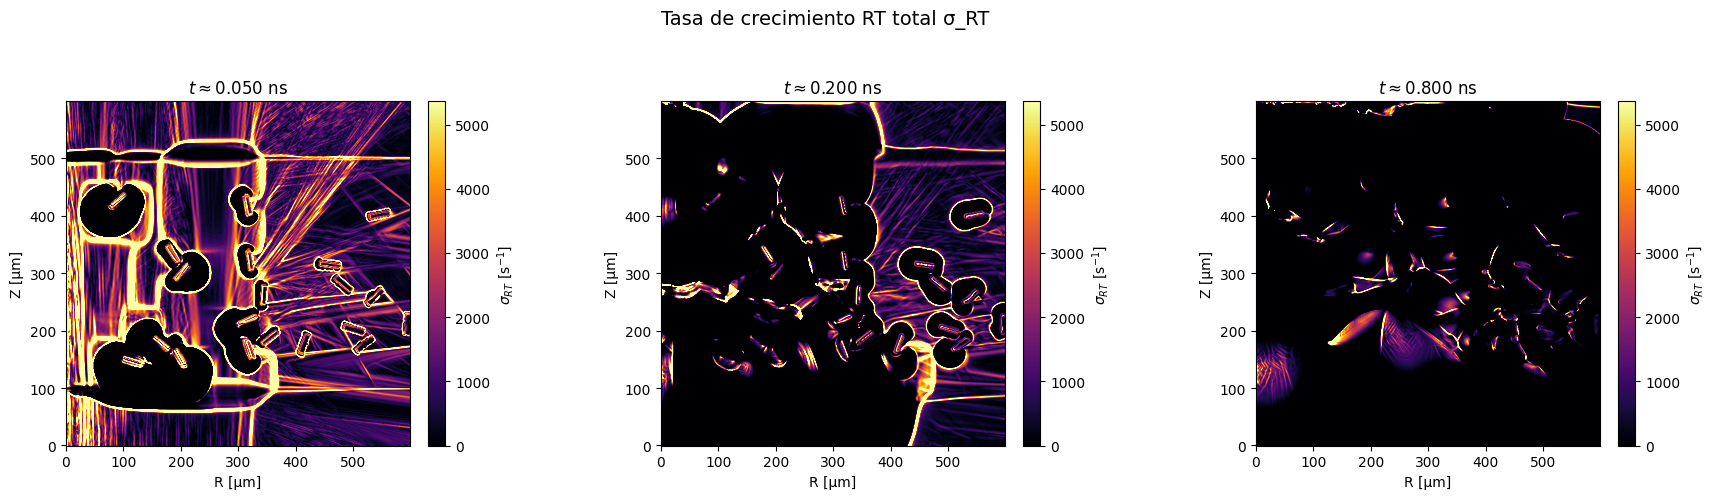

In [14]:
ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD.h5"]

tiempos_ns = [ 0.01, 0.06, 0.2]
t_ns2 = [ 0.05, 0.2, 0.8]

for r in ruta_hdf5:
    #vr_RT_total_por_tiempos(
     #  r,
     #  tiempos_ns= t_ns2
    #

    ver_RT_total_por_tiempos(
        r,
        tiempos_ns = t_ns2
    )


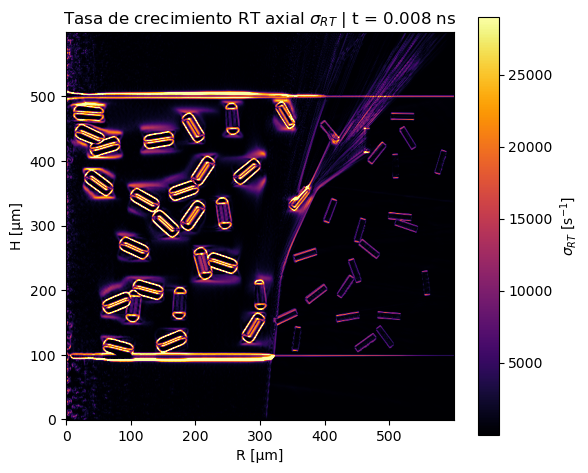

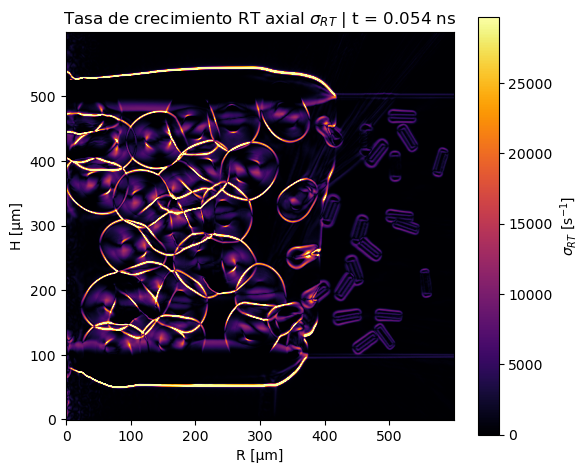

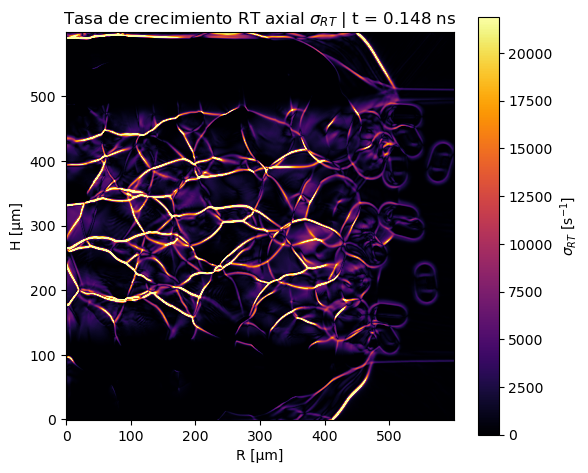

In [60]:
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LD.h5"
t_index = [5, 33, 131]

for t in t_index:
    ver_RT_axial_por_indice(ruta_hdf5, t)
